In [1]:
import os
import time
import random
import warnings
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, cohen_kappa_score, roc_auc_score, 
    precision_recall_curve, auc, classification_report, confusion_matrix
)
from scipy.stats import pearsonr

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

warnings.filterwarnings("ignore")
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
class Config:

    DATA_DIR = "DL_Assignment1_Dataset\Dataset\Dataset"

    BATCH_SIZE = 16
    EPOCHS = 30
    LEARNING_RATE = 1e-4

    NUM_CLASSES = 8
    IMAGE_SIZE = 224
    NUM_LANDMARKS = 136

    LOSS_WEIGHTS = {
        "expression": 1.0,
        "valence": 0.5,  
        "arousal": 0.5
    }
    
    FREEZE_EPOCHS = 5
    NUM_WORKERS = 0
    
    # Reproducibility
    SEED = 42

    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    EXPRESSION_NAMES = {
        0: "Neutral", 1: "Happy", 2: "Sad", 3: "Surprise",
        4: "Fear", 5: "Disgust", 6: "Anger", 7: "Contempt"
    }

def set_seed(seed=Config.SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed()

## Dataset Analysis and spliting

In [3]:
def load_annotation_safely(file_path):
    try:
        data = np.load(file_path, allow_pickle=True)
        if isinstance(data, np.ndarray) and data.size == 1:
            return data.item()
        return data
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

def analyze_dataset():
    
    images_dir = os.path.join(Config.DATA_DIR, "images")
    annotations_dir = os.path.join(Config.DATA_DIR, "annotations")
    
    if not os.path.exists(images_dir):
        raise FileNotFoundError(f"Images directory not found: {images_dir}")
    if not os.path.exists(annotations_dir):
        raise FileNotFoundError(f"Annotations directory not found: {annotations_dir}")
    
    image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]
    
    valid_samples = []
    expression_counts = Counter()
    valence_values = []
    arousal_values = []
    
    for img_file in tqdm(image_files[:100], desc="Sampling annotations"):
        img_id = img_file.split('.')[0]
        exp_path = os.path.join(annotations_dir, f"{img_id}_exp.npy")
        val_path = os.path.join(annotations_dir, f"{img_id}_val.npy")
        aro_path = os.path.join(annotations_dir, f"{img_id}_aro.npy")
        lnd_path = os.path.join(annotations_dir, f"{img_id}_lnd.npy")
        
        if all(os.path.exists(p) for p in [exp_path, val_path, aro_path, lnd_path]):
            try:
                expression = load_annotation_safely(exp_path)
                valence = load_annotation_safely(val_path)
                arousal = load_annotation_safely(aro_path)
                landmarks = load_annotation_safely(lnd_path)
                
                if (valence != -2 and arousal != -2 and 
                    expression is not None and landmarks is not None):
                    valid_samples.append(img_id)
                    expression_counts[int(expression)] += 1
                    valence_values.append(float(valence))
                    arousal_values.append(float(arousal))
                    
            except Exception as e:
                print(f"Error processing {img_id}: {e}")
    
    print(f"Valid samples in first 100: {len(valid_samples)}")
    print(f"Expression distribution: {dict(expression_counts)}")
    print(f"Valence range: [{min(valence_values):.3f}, {max(valence_values):.3f}]")
    print(f"Arousal range: [{min(arousal_values):.3f}, {max(arousal_values):.3f}]")
    
    return len(image_files)

total_images = analyze_dataset()

Sampling annotations: 100%|██████████| 100/100 [00:03<00:00, 27.05it/s]

Valid samples in first 100: 100
Expression distribution: {0: 15, 7: 20, 3: 7, 4: 10, 5: 4, 2: 27, 6: 8, 1: 9}
Valence range: [-0.944, 0.876]
Arousal range: [-0.627, 0.958]


In [4]:
def create_data_splits():
    
    images_dir = os.path.join(Config.DATA_DIR, "images")
    annotations_dir = os.path.join(Config.DATA_DIR, "annotations")
    
    image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]
    valid_ids = []
    
    for img_file in tqdm(image_files, desc="Processing images"):
        img_id = img_file.split('.')[0]
        exp_path = os.path.join(annotations_dir, f"{img_id}_exp.npy")
        val_path = os.path.join(annotations_dir, f"{img_id}_val.npy")
        aro_path = os.path.join(annotations_dir, f"{img_id}_aro.npy")
        lnd_path = os.path.join(annotations_dir, f"{img_id}_lnd.npy")
        
        if all(os.path.exists(p) for p in [exp_path, val_path, aro_path, lnd_path]):
            try:
                valence = load_annotation_safely(val_path)
                arousal = load_annotation_safely(aro_path)
                if valence != -2 and arousal != -2:
                    valid_ids.append(img_id)
            except Exception:
                continue
    
    train_ids, temp_ids = train_test_split(
        valid_ids, test_size=0.3, random_state=Config.SEED, shuffle=True
    )
    val_ids, test_ids = train_test_split(
        temp_ids, test_size=0.5, random_state=Config.SEED, shuffle=True
    )
    
    print(f"Training samples: {len(train_ids)}")
    print(f"Validation samples: {len(val_ids)}")
    print(f"Test samples: {len(test_ids)}")
    
    return train_ids, val_ids, test_ids

train_ids, val_ids, test_ids = create_data_splits()

Processing images: 100%|██████████| 3999/3999 [00:47<00:00, 84.64it/s] 

Training samples: 2799
Validation samples: 600
Test samples: 600


In [5]:
class FacialEmotionDataset(Dataset):
    
    def __init__(self, data_dir, image_ids, transform=None, include_landmarks=True):
        self.data_dir = data_dir
        self.image_ids = image_ids
        self.transform = transform
        self.include_landmarks = include_landmarks
        self.annotations = {}
        self._load_annotations()
    
    def _load_annotations(self):
        print(f"Loading annotations for {len(self.image_ids)} samples...")
        for img_id in tqdm(self.image_ids, desc="Loading annotations"):
            try:
                exp_path = os.path.join(self.data_dir, "annotations", f"{img_id}_exp.npy")
                val_path = os.path.join(self.data_dir, "annotations", f"{img_id}_val.npy")
                aro_path = os.path.join(self.data_dir, "annotations", f"{img_id}_aro.npy")
                lnd_path = os.path.join(self.data_dir, "annotations", f"{img_id}_lnd.npy")
                
                expression = int(load_annotation_safely(exp_path))
                valence = float(load_annotation_safely(val_path))
                arousal = float(load_annotation_safely(aro_path))
                landmarks = load_annotation_safely(lnd_path)
                
                if landmarks is not None:
                    landmarks = np.array(landmarks, dtype=np.float32).flatten()
                    landmarks = (landmarks / 112.0) - 1.0
                else:
                    landmarks = np.zeros(Config.NUM_LANDMARKS, dtype=np.float32)
                
                self.annotations[img_id] = {
                    'expression': expression,
                    'valence': valence,
                    'arousal': arousal,
                    'landmarks': landmarks
                }
            except Exception as e:
                print(f"Warning: Error loading {img_id}: {e}")
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_path = os.path.join(self.data_dir, "images", f"{img_id}.jpg")
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        ann = self.annotations[img_id]
        sample = {
            'image': image,
            'expression': torch.tensor(ann['expression'], dtype=torch.long),
            'valence': torch.tensor(ann['valence'], dtype=torch.float32),
            'arousal': torch.tensor(ann['arousal'], dtype=torch.float32),
            'image_id': img_id
        }
        if self.include_landmarks:
            sample['landmarks'] = torch.tensor(ann['landmarks'], dtype=torch.float32)
        return sample
        
    def get_class_distribution(self):
        expressions = [self.annotations[img_id]['expression'] for img_id in self.image_ids]
        return Counter(expressions)

In [6]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((Config.IMAGE_SIZE, Config.IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.33), ratio=(0.3, 3.3))
])

val_transform = transforms.Compose([
    transforms.Resize((Config.IMAGE_SIZE, Config.IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Model Architecture

In [7]:
class MultiTaskEmotionNet(nn.Module):
    def __init__(self, backbone, backbone_dim, num_classes=8, use_landmarks=True):
        super(MultiTaskEmotionNet, self).__init__()
        self.use_landmarks = use_landmarks
        self.backbone = backbone
        feat_dim = backbone_dim
        if use_landmarks:
            feat_dim += Config.NUM_LANDMARKS
        self.feature_fusion = nn.Sequential(
            nn.Linear(feat_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3)
        )
        self.expression_head = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
        self.valence_head = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(128, 1),
            nn.Tanh()
        )
        self.arousal_head = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(128, 1),
            nn.Tanh()
        )
    
    def forward(self, images, landmarks=None):
        image_features = self.backbone(images)
        if image_features.dim() > 2:
            image_features = image_features.view(image_features.size(0), -1)
        if self.use_landmarks and landmarks is not None:
            landmarks = landmarks.to(image_features.device).to(image_features.dtype)
            features = torch.cat([image_features, landmarks], dim=1)
        else:
            features = image_features
        fused_features = self.feature_fusion(features)
        expression_logits = self.expression_head(fused_features)
        valence_pred = self.valence_head(fused_features).squeeze(-1)
        arousal_pred = self.arousal_head(fused_features).squeeze(-1)
        return {
            'expression': expression_logits,
            'valence': valence_pred,
            'arousal': arousal_pred
        }

def build_resnet50_model(use_landmarks=True):
    resnet = models.resnet50(pretrained=True)
    resnet.fc = nn.Identity()
    model = MultiTaskEmotionNet(
        backbone=resnet,
        backbone_dim=2048,
        num_classes=Config.NUM_CLASSES,
        use_landmarks=use_landmarks
    )
    return model

def build_efficientnet_b3_model(use_landmarks=True):
    try:
        from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights
        efficientnet = efficientnet_b3(weights=EfficientNet_B3_Weights.IMAGENET1K_V1)
        efficientnet.classifier = nn.Identity()
        model = MultiTaskEmotionNet(
            backbone=efficientnet,
            backbone_dim=1536,
            num_classes=Config.NUM_CLASSES,
            use_landmarks=use_landmarks
        )
        return model
    except ImportError:
        return build_resnet50_model(use_landmarks)

## Evaluation class

In [8]:
class EvaluationMetrics:
    @staticmethod
    def rmse(y_true, y_pred):
        return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred)) ** 2))
    
    @staticmethod
    def pearson_correlation(y_true, y_pred):
        try:
            corr, _ = pearsonr(y_true, y_pred)
            return corr if not np.isnan(corr) else 0.0
        except:
            return 0.0
    
    @staticmethod
    def sign_agreement(y_true, y_pred):
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        return np.mean(np.sign(y_true) == np.sign(y_pred))
    
    @staticmethod
    def concordance_correlation_coefficient(y_true, y_pred):
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        mean_true = np.mean(y_true)
        mean_pred = np.mean(y_pred)
        var_true = np.var(y_true)
        var_pred = np.var(y_pred)
        covariance = np.mean((y_true - mean_true) * (y_pred - mean_pred))
        denominator = var_true + var_pred + (mean_true - mean_pred) ** 2
        if denominator == 0:
            return 0.0
        return (2 * covariance) / denominator
    
    @staticmethod
    def krippendorff_alpha(y_true, y_pred):
        try:
            data = np.vstack([y_true, y_pred])
            categories = np.unique(data)
            n_pairs = len(y_true)
            observed_disagreement = np.sum(y_true != y_pred) / n_pairs
            category_counts = {cat: np.sum(data == cat) for cat in categories}
            total_values = 2 * n_pairs
            expected_disagreement = 0
            for cat1 in categories:
                for cat2 in categories:
                    if cat1 != cat2:
                        prob1 = category_counts[cat1] / total_values
                        prob2 = category_counts[cat2] / total_values
                        expected_disagreement += prob1 * prob2
            if expected_disagreement == 0:
                return 1.0 if observed_disagreement == 0 else 0.0
            return 1 - (observed_disagreement / expected_disagreement)
        except:
            return 0.0

def evaluate_model(model, dataloader, device):
    model.eval()
    all_exp_preds, all_exp_true = [], []
    all_val_preds, all_val_true = [], []
    all_aro_preds, all_aro_true = [], []
    all_exp_probs = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            images = batch['image'].to(device)
            landmarks = batch.get('landmarks')
            if landmarks is not None:
                landmarks = landmarks.to(device)
            exp_true = batch['expression'].cpu().numpy()
            val_true = batch['valence'].cpu().numpy()
            aro_true = batch['arousal'].cpu().numpy()
            outputs = model(images, landmarks)
            exp_logits = outputs['expression'].cpu()
            exp_probs = torch.softmax(exp_logits, dim=1).numpy()
            exp_preds = np.argmax(exp_probs, axis=1)
            all_exp_preds.extend(exp_preds)
            all_exp_true.extend(exp_true)
            all_exp_probs.append(exp_probs)
            all_val_preds.extend(outputs['valence'].cpu().numpy())
            all_val_true.extend(val_true)
            all_aro_preds.extend(outputs['arousal'].cpu().numpy())
            all_aro_true.extend(aro_true)
    
    all_exp_probs = np.vstack(all_exp_probs) if all_exp_probs else np.zeros((len(all_exp_preds), Config.NUM_CLASSES))
    metrics = {}
    metrics['accuracy'] = accuracy_score(all_exp_true, all_exp_preds)
    metrics['f1_micro'] = f1_score(all_exp_true, all_exp_preds, average='micro', zero_division=0)
    metrics['f1_macro'] = f1_score(all_exp_true, all_exp_preds, average='macro', zero_division=0)
    try:
        metrics['cohens_kappa'] = cohen_kappa_score(all_exp_true, all_exp_preds)
    except:
        metrics['cohens_kappa'] = 0.0
    metrics['krippendorff_alpha'] = EvaluationMetrics.krippendorff_alpha(all_exp_true, all_exp_preds)
    try:
        y_onehot = np.eye(Config.NUM_CLASSES)[all_exp_true]
        metrics['roc_auc'] = roc_auc_score(y_onehot, all_exp_probs, average='macro', multi_class='ovr')
    except:
        metrics['roc_auc'] = 0.0
    try:
        pr_aucs = []
        for class_idx in range(Config.NUM_CLASSES):
            y_true_binary = (np.array(all_exp_true) == class_idx).astype(int)
            if np.sum(y_true_binary) > 0:
                precision, recall, _ = precision_recall_curve(y_true_binary, all_exp_probs[:, class_idx])
                pr_aucs.append(auc(recall, precision))
        metrics['pr_auc'] = np.mean(pr_aucs) if pr_aucs else 0.0
    except:
        metrics['pr_auc'] = 0.0
    
    metrics['valence_rmse'] = EvaluationMetrics.rmse(all_val_true, all_val_preds)
    metrics['valence_corr'] = EvaluationMetrics.pearson_correlation(all_val_true, all_val_preds)
    metrics['valence_sagr'] = EvaluationMetrics.sign_agreement(all_val_true, all_val_preds)
    metrics['valence_ccc'] = EvaluationMetrics.concordance_correlation_coefficient(all_val_true, all_val_preds)
    
    metrics['arousal_rmse'] = EvaluationMetrics.rmse(all_aro_true, all_aro_preds)
    metrics['arousal_corr'] = EvaluationMetrics.pearson_correlation(all_aro_true, all_aro_preds)
    metrics['arousal_sagr'] = EvaluationMetrics.sign_agreement(all_aro_true, all_aro_preds)
    metrics['arousal_ccc'] = EvaluationMetrics.concordance_correlation_coefficient(all_aro_true, all_aro_preds)
    
    metrics['predictions'] = {
        'expression': (all_exp_preds, all_exp_true, all_exp_probs),
        'valence': (all_val_preds, all_val_true),
        'arousal': (all_aro_preds, all_aro_true)
    }
    
    return metrics

# Traning pipeline

In [9]:
class MultiTaskLoss(nn.Module):
    
    def __init__(self, loss_weights=None):
        super(MultiTaskLoss, self).__init__()
        
        self.loss_weights = loss_weights or Config.LOSS_WEIGHTS

        self.classification_loss = nn.CrossEntropyLoss()
        self.regression_loss = nn.MSELoss()
        
    def forward(self, predictions, targets):
        exp_loss = self.classification_loss(predictions['expression'], targets['expression'])
        val_loss = self.regression_loss(predictions['valence'], targets['valence'])
        aro_loss = self.regression_loss(predictions['arousal'], targets['arousal'])
   
        total_loss = (
            self.loss_weights['expression'] * exp_loss +
            self.loss_weights['valence'] * val_loss +
            self.loss_weights['arousal'] * aro_loss
        )
        
        return {
            'total_loss': total_loss,
            'expression_loss': exp_loss,
            'valence_loss': val_loss,
            'arousal_loss': aro_loss
        }

def train_model(model, train_loader, val_loader, model_name, epochs=Config.EPOCHS):
    
    print(f"Training {model_name}")
    print("=" * 60)

    criterion = MultiTaskLoss()

    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=Config.LEARNING_RATE,
        weight_decay=1e-4
    )

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=3
    )

    history = {
        'train_loss': [], 'val_loss': [],
        'val_accuracy': [], 'val_f1': [],
        'val_valence_rmse': [], 'val_arousal_rmse': []
    }
    
    best_val_acc = 0.0
    patience_counter = 0
    
    if Config.FREEZE_EPOCHS > 0:
        for param in model.backbone.parameters():
            param.requires_grad = False
       
    
    for epoch in range(epochs):
        start_time = time.time()
        
        model.train()
        train_loss = 0.0
        train_batches = 0
        
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', leave=False)
        for batch in train_pbar:
            images = batch['image'].to(Config.DEVICE)
            landmarks = batch.get('landmarks')
            if landmarks is not None:
                landmarks = landmarks.to(Config.DEVICE)
            
            targets = {
                'expression': batch['expression'].to(Config.DEVICE),
                'valence': batch['valence'].to(Config.DEVICE),
                'arousal': batch['arousal'].to(Config.DEVICE)
            }

            optimizer.zero_grad()
            predictions = model(images, landmarks)
            loss_dict = criterion(predictions, targets)

            loss_dict['total_loss'].backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss_dict['total_loss'].item()
            train_batches += 1

            train_pbar.set_postfix({
                'Loss': f"{loss_dict['total_loss'].item():.4f}",
                'LR': f"{optimizer.param_groups[0]['lr']:.6f}"
            })
        
        if epoch + 1 == Config.FREEZE_EPOCHS and Config.FREEZE_EPOCHS > 0:
            for param in model.backbone.parameters():
                param.requires_grad = True

            optimizer = optim.Adam(
                model.parameters(),
                lr=Config.LEARNING_RATE * 0.1,
                weight_decay=1e-4
            )
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode='max', factor=0.5, patience=3
            )

        val_metrics = evaluate_model(model, val_loader, Config.DEVICE)

        avg_train_loss = train_loss / max(1, train_batches)
        history['train_loss'].append(avg_train_loss)
        history['val_accuracy'].append(val_metrics['accuracy'])
        history['val_f1'].append(val_metrics['f1_macro'])
        history['val_valence_rmse'].append(val_metrics['valence_rmse'])
        history['val_arousal_rmse'].append(val_metrics['arousal_rmse'])
        
        epoch_time = time.time() - start_time
        print(f"Epoch {epoch+1:2d}/{epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Acc: {val_metrics['accuracy']:.4f} | "
              f"Val F1: {val_metrics['f1_macro']:.4f} | "
              f"Val RMSE (V/A): {val_metrics['valence_rmse']:.3f}/{val_metrics['arousal_rmse']:.3f} | "
              f"Time: {epoch_time:.1f}s")
        
        if val_metrics['accuracy'] > best_val_acc:
            best_val_acc = val_metrics['accuracy']
            patience_counter = 0
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch,
                'best_val_acc': best_val_acc,
                'config': {
                    'NUM_CLASSES': Config.NUM_CLASSES,
                    'IMAGE_SIZE': Config.IMAGE_SIZE,
                    'BATCH_SIZE': Config.BATCH_SIZE,
                    'LEARNING_RATE': Config.LEARNING_RATE
                }
            }, f'{model_name}_best.pth')
        else:
            patience_counter += 1
 
        scheduler.step(val_metrics['accuracy'])

        if patience_counter >= 7:
            print(f"Early stopping")
            break
    
    print(f"Training Best validation accuracy: {best_val_acc:.4f}")
    return history, best_val_acc

In [10]:
train_dataset = FacialEmotionDataset(
    data_dir=Config.DATA_DIR,
    image_ids=train_ids,
    transform=train_transform,
    include_landmarks=True
)

val_dataset = FacialEmotionDataset(
    data_dir=Config.DATA_DIR,
    image_ids=val_ids,
    transform=val_transform,
    include_landmarks=True
)

test_dataset = FacialEmotionDataset(
    data_dir=Config.DATA_DIR,
    image_ids=test_ids,
    transform=val_transform,
    include_landmarks=True
)

train_loader = DataLoader(
    train_dataset,
    batch_size=Config.BATCH_SIZE,
    shuffle=True,
    num_workers=Config.NUM_WORKERS,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=Config.BATCH_SIZE,
    shuffle=False,
    num_workers=Config.NUM_WORKERS
)

test_loader = DataLoader(
    test_dataset,
    batch_size=Config.BATCH_SIZE,
    shuffle=False,
    num_workers=Config.NUM_WORKERS
)

train_dist = train_dataset.get_class_distribution()
for class_id, count in sorted(train_dist.items()):
    print(f"{Config.EXPRESSION_NAMES[class_id]}: {count} samples")

Loading annotations for 2799 samples...


Loading annotations: 100%|██████████| 2799/2799 [00:45<00:00, 61.18it/s]


Loading annotations for 600 samples...


Loading annotations: 100%|██████████| 600/600 [00:09<00:00, 61.99it/s]


Loading annotations for 600 samples...


Loading annotations: 100%|██████████| 600/600 [00:10<00:00, 57.91it/s]

Neutral: 360 samples
Happy: 351 samples
Sad: 353 samples
Surprise: 366 samples
Fear: 349 samples
Disgust: 338 samples
Anger: 344 samples
Contempt: 338 samples


## Model Traning 

In [11]:
resnet_model = build_resnet50_model(use_landmarks=True).to(Config.DEVICE)
resnet_params = sum(p.numel() for p in resnet_model.parameters())
print(f"ResNet50 Model Parameters: {resnet_params:,}")

efficientnet_model = build_efficientnet_b3_model(use_landmarks=True).to(Config.DEVICE)
efficientnet_params = sum(p.numel() for p in efficientnet_model.parameters())
print(f"EfficientNet-B3 Model Parameters: {efficientnet_params:,}")

print(f"\nUsing device: {Config.DEVICE}")
print("=" * 80)

ResNet50 Model Parameters: 24,892,746
EfficientNet-B3 Model Parameters: 11,818,802

Using device: cpu


In [12]:
print("TRAINING RESNET50")

resnet_history, resnet_best_acc = train_model(
    model=resnet_model,
    train_loader=train_loader,
    val_loader=val_loader,
    model_name="resnet50",
    epochs=Config.EPOCHS
)

TRAINING RESNET50
Training resnet50


Epoch  1/30 | Train Loss: 2.2259 | Val Acc: 0.1983 | Val F1: 0.1593 | Val RMSE (V/A): 0.469/0.366 | Time: 268.5s


Epoch  2/30 | Train Loss: 2.1184 | Val Acc: 0.2350 | Val F1: 0.2095 | Val RMSE (V/A): 0.465/0.361 | Time: 252.6s


Epoch  3/30 | Train Loss: 2.0427 | Val Acc: 0.2350 | Val F1: 0.1870 | Val RMSE (V/A): 0.467/0.362 | Time: 248.3s


Epoch  4/30 | Train Loss: 1.9958 | Val Acc: 0.2717 | Val F1: 0.2539 | Val RMSE (V/A): 0.458/0.367 | Time: 226.5s


Epoch  5/30 | Train Loss: 1.9798 | Val Acc: 0.2583 | Val F1: 0.2447 | Val RMSE (V/A): 0.464/0.362 | Time: 234.1s


Epoch  6/30 | Train Loss: 1.9146 | Val Acc: 0.2767 | Val F1: 0.2708 | Val RMSE (V/A): 0.446/0.357 | Time: 613.7s


Epoch  7/30 | Train Loss: 1.8316 | Val Acc: 0.3283 | Val F1: 0.3233 | Val RMSE (V/A): 0.432/0.353 | Time: 603.2s


Epoch  8/30 | Train Loss: 1.7415 | Val Acc: 0.3467 | Val F1: 0.3401 | Val RMSE (V/A): 0.427/0.355 | Time: 547.3s


Epoch  9/30 | Train Loss: 1.7087 | Val Acc: 0.3583 | Val F1: 0.3579 | Val RMSE (V/A): 0.423/0.351 | Time: 542.4s


Epoch 10/30 | Train Loss: 1.6612 | Val Acc: 0.3733 | Val F1: 0.3720 | Val RMSE (V/A): 0.413/0.350 | Time: 503.0s


Epoch 11/30 | Train Loss: 1.6021 | Val Acc: 0.3900 | Val F1: 0.3924 | Val RMSE (V/A): 0.413/0.347 | Time: 542.6s


Epoch 12/30 | Train Loss: 1.5577 | Val Acc: 0.4083 | Val F1: 0.4063 | Val RMSE (V/A): 0.406/0.345 | Time: 545.6s


Epoch 13/30 | Train Loss: 1.5005 | Val Acc: 0.4083 | Val F1: 0.4044 | Val RMSE (V/A): 0.402/0.345 | Time: 544.3s


Epoch 14/30 | Train Loss: 1.4354 | Val Acc: 0.4150 | Val F1: 0.4156 | Val RMSE (V/A): 0.406/0.343 | Time: 541.9s


Epoch 15/30 | Train Loss: 1.3947 | Val Acc: 0.4050 | Val F1: 0.4024 | Val RMSE (V/A): 0.406/0.340 | Time: 543.8s


Epoch 16/30 | Train Loss: 1.3773 | Val Acc: 0.4217 | Val F1: 0.4201 | Val RMSE (V/A): 0.398/0.344 | Time: 541.2s


Epoch 17/30 | Train Loss: 1.3079 | Val Acc: 0.4217 | Val F1: 0.4187 | Val RMSE (V/A): 0.403/0.341 | Time: 543.7s


Epoch 18/30 | Train Loss: 1.2723 | Val Acc: 0.4150 | Val F1: 0.4095 | Val RMSE (V/A): 0.396/0.339 | Time: 540.2s


Epoch 19/30 | Train Loss: 1.2344 | Val Acc: 0.4200 | Val F1: 0.4150 | Val RMSE (V/A): 0.403/0.343 | Time: 541.9s


Epoch 20/30 | Train Loss: 1.1986 | Val Acc: 0.4433 | Val F1: 0.4402 | Val RMSE (V/A): 0.400/0.345 | Time: 541.7s


Epoch 21/30 | Train Loss: 1.1523 | Val Acc: 0.4250 | Val F1: 0.4203 | Val RMSE (V/A): 0.403/0.343 | Time: 543.8s


Epoch 22/30 | Train Loss: 1.1124 | Val Acc: 0.4300 | Val F1: 0.4224 | Val RMSE (V/A): 0.400/0.340 | Time: 541.3s


Epoch 23/30 | Train Loss: 1.0708 | Val Acc: 0.4217 | Val F1: 0.4160 | Val RMSE (V/A): 0.404/0.341 | Time: 540.4s


Epoch 24/30 | Train Loss: 1.0570 | Val Acc: 0.4383 | Val F1: 0.4345 | Val RMSE (V/A): 0.399/0.341 | Time: 539.8s


Epoch 25/30 | Train Loss: 1.0002 | Val Acc: 0.4467 | Val F1: 0.4389 | Val RMSE (V/A): 0.401/0.339 | Time: 539.8s


Epoch 26/30 | Train Loss: 0.9477 | Val Acc: 0.4417 | Val F1: 0.4372 | Val RMSE (V/A): 0.405/0.340 | Time: 544.4s


Epoch 27/30 | Train Loss: 0.9258 | Val Acc: 0.4150 | Val F1: 0.4140 | Val RMSE (V/A): 0.405/0.338 | Time: 543.0s


Epoch 28/30 | Train Loss: 0.9278 | Val Acc: 0.4400 | Val F1: 0.4358 | Val RMSE (V/A): 0.406/0.339 | Time: 542.6s


Epoch 29/30 | Train Loss: 0.9009 | Val Acc: 0.4217 | Val F1: 0.4131 | Val RMSE (V/A): 0.414/0.342 | Time: 541.1s


Epoch 30/30 | Train Loss: 0.8655 | Val Acc: 0.4483 | Val F1: 0.4442 | Val RMSE (V/A): 0.401/0.336 | Time: 540.9s
Training Best validation accuracy: 0.4483


In [13]:
efficientnet_history, efficientnet_best_acc = train_model(
    model=efficientnet_model,
    train_loader=train_loader,
    val_loader=val_loader,
    model_name="efficientnet_b3",
    epochs=Config.EPOCHS
)

Training efficientnet_b3


Epoch  1/30 | Train Loss: 2.2498 | Val Acc: 0.2133 | Val F1: 0.1833 | Val RMSE (V/A): 0.473/0.373 | Time: 187.5s


Epoch  2/30 | Train Loss: 2.1584 | Val Acc: 0.2650 | Val F1: 0.2297 | Val RMSE (V/A): 0.462/0.366 | Time: 185.0s


Epoch  3/30 | Train Loss: 2.0780 | Val Acc: 0.2683 | Val F1: 0.2434 | Val RMSE (V/A): 0.458/0.362 | Time: 185.1s


Epoch  4/30 | Train Loss: 2.0387 | Val Acc: 0.2850 | Val F1: 0.2556 | Val RMSE (V/A): 0.453/0.360 | Time: 185.0s


Epoch  5/30 | Train Loss: 1.9998 | Val Acc: 0.2817 | Val F1: 0.2568 | Val RMSE (V/A): 0.448/0.359 | Time: 186.8s


Epoch  6/30 | Train Loss: 1.9684 | Val Acc: 0.3100 | Val F1: 0.2914 | Val RMSE (V/A): 0.444/0.358 | Time: 523.8s


Epoch  7/30 | Train Loss: 1.9440 | Val Acc: 0.3200 | Val F1: 0.3046 | Val RMSE (V/A): 0.440/0.357 | Time: 517.9s


Epoch  8/30 | Train Loss: 1.9181 | Val Acc: 0.3183 | Val F1: 0.3048 | Val RMSE (V/A): 0.440/0.358 | Time: 518.0s


Epoch  9/30 | Train Loss: 1.9129 | Val Acc: 0.3283 | Val F1: 0.3153 | Val RMSE (V/A): 0.433/0.356 | Time: 511.3s


Epoch 10/30 | Train Loss: 1.8675 | Val Acc: 0.3517 | Val F1: 0.3378 | Val RMSE (V/A): 0.436/0.354 | Time: 512.2s


Epoch 11/30 | Train Loss: 1.8503 | Val Acc: 0.3450 | Val F1: 0.3316 | Val RMSE (V/A): 0.431/0.355 | Time: 504.6s


Epoch 12/30 | Train Loss: 1.8379 | Val Acc: 0.3450 | Val F1: 0.3297 | Val RMSE (V/A): 0.428/0.353 | Time: 492.3s


Epoch 13/30 | Train Loss: 1.8072 | Val Acc: 0.3533 | Val F1: 0.3418 | Val RMSE (V/A): 0.422/0.354 | Time: 507.2s


Epoch 14/30 | Train Loss: 1.8012 | Val Acc: 0.3567 | Val F1: 0.3454 | Val RMSE (V/A): 0.422/0.353 | Time: 515.3s


Epoch 15/30 | Train Loss: 1.7837 | Val Acc: 0.3650 | Val F1: 0.3588 | Val RMSE (V/A): 0.420/0.351 | Time: 511.8s


Epoch 16/30 | Train Loss: 1.7559 | Val Acc: 0.3517 | Val F1: 0.3419 | Val RMSE (V/A): 0.416/0.350 | Time: 515.8s


Epoch 17/30 | Train Loss: 1.7343 | Val Acc: 0.3433 | Val F1: 0.3346 | Val RMSE (V/A): 0.415/0.352 | Time: 508.1s


Epoch 18/30 | Train Loss: 1.7073 | Val Acc: 0.3567 | Val F1: 0.3466 | Val RMSE (V/A): 0.417/0.352 | Time: 509.0s


Epoch 19/30 | Train Loss: 1.7064 | Val Acc: 0.3667 | Val F1: 0.3579 | Val RMSE (V/A): 0.415/0.350 | Time: 689.0s


Epoch 20/30 | Train Loss: 1.6825 | Val Acc: 0.3567 | Val F1: 0.3476 | Val RMSE (V/A): 0.415/0.349 | Time: 695.5s


Epoch 21/30 | Train Loss: 1.6707 | Val Acc: 0.3600 | Val F1: 0.3498 | Val RMSE (V/A): 0.412/0.348 | Time: 689.0s


Epoch 22/30 | Train Loss: 1.6654 | Val Acc: 0.3767 | Val F1: 0.3709 | Val RMSE (V/A): 0.408/0.348 | Time: 1039.3s


Epoch 23/30 | Train Loss: 1.6440 | Val Acc: 0.3717 | Val F1: 0.3689 | Val RMSE (V/A): 0.408/0.349 | Time: 525.0s


Epoch 24/30 | Train Loss: 1.6461 | Val Acc: 0.3817 | Val F1: 0.3815 | Val RMSE (V/A): 0.409/0.348 | Time: 505.2s


Epoch 25/30 | Train Loss: 1.6348 | Val Acc: 0.3817 | Val F1: 0.3783 | Val RMSE (V/A): 0.405/0.347 | Time: 514.2s


Epoch 26/30 | Train Loss: 1.5903 | Val Acc: 0.3817 | Val F1: 0.3748 | Val RMSE (V/A): 0.407/0.346 | Time: 498.1s


Epoch 27/30 | Train Loss: 1.5849 | Val Acc: 0.3850 | Val F1: 0.3795 | Val RMSE (V/A): 0.406/0.347 | Time: 523.3s


Epoch 28/30 | Train Loss: 1.5632 | Val Acc: 0.4117 | Val F1: 0.4089 | Val RMSE (V/A): 0.405/0.346 | Time: 507.1s


Epoch 29/30 | Train Loss: 1.5612 | Val Acc: 0.4050 | Val F1: 0.4041 | Val RMSE (V/A): 0.402/0.343 | Time: 506.1s


Epoch 30/30 | Train Loss: 1.5432 | Val Acc: 0.4017 | Val F1: 0.4002 | Val RMSE (V/A): 0.401/0.345 | Time: 484.3s
Training Best validation accuracy: 0.4117


In [14]:
trained_models = {
    'ResNet50': resnet_model,
    'EfficientNet-B3': efficientnet_model
}

training_results = {
    'ResNet50': resnet_history,
    'EfficientNet-B3': efficientnet_history
}

print(f"Available models: {list(trained_models.keys())}")
print("="*60)

Available models: ['ResNet50', 'EfficientNet-B3']


## model compare final evaluation

In [15]:
print("MODEL COMPARISON RESULTS")
print("=" * 60)
print(f"ResNet50 Best Validation Accuracy: {resnet_best_acc:.4f}")
print(f"EfficientNet-B3 Best Validation Accuracy: {efficientnet_best_acc:.4f}")

if resnet_best_acc >= efficientnet_best_acc:
    best_model_name = "resnet50"
    best_model = build_resnet50_model(use_landmarks=True).to(Config.DEVICE)
    winner_acc = resnet_best_acc
else:
    best_model_name = "efficientnet_b3"
    best_model = build_efficientnet_b3_model(use_landmarks=True).to(Config.DEVICE)
    winner_acc = efficientnet_best_acc

print(f"\nWinner: {best_model_name.upper()} with {winner_acc:.4f} accuracy")

checkpoint = torch.load(f'{best_model_name}_best.pth', map_location=Config.DEVICE)
best_model.load_state_dict(checkpoint['model_state_dict'])
print(f"Best {best_model_name} model loaded successfully!")

print(f"\nFINAL TEST SET EVALUATION - {best_model_name.upper()}")
print("=" * 60)

test_metrics = evaluate_model(best_model, test_loader, Config.DEVICE)

print("\nCLASSIFICATION METRICS:")
print(f"   Accuracy: {test_metrics['accuracy']:.4f}")
print(f"   F1-Score (Micro): {test_metrics['f1_micro']:.4f}")
print(f"   F1-Score (Macro): {test_metrics['f1_macro']:.4f}")
print(f"   Cohen's Kappa: {test_metrics['cohens_kappa']:.4f}")
print(f"   Krippendorff's Alpha: {test_metrics['krippendorff_alpha']:.4f}")
print(f"   ROC-AUC: {test_metrics['roc_auc']:.4f}")
print(f"   PR-AUC: {test_metrics['pr_auc']:.4f}")

print("\nVALENCE REGRESSION METRICS:")
print(f"   RMSE: {test_metrics['valence_rmse']:.4f}")
print(f"   Correlation: {test_metrics['valence_corr']:.4f}")
print(f"   Sign Agreement (SAGR): {test_metrics['valence_sagr']:.4f}")
print(f"   Concordance Correlation (CCC): {test_metrics['valence_ccc']:.4f}")

print("\nAROUSAL REGRESSION METRICS:")
print(f"   RMSE: {test_metrics['arousal_rmse']:.4f}")
print(f"   Correlation: {test_metrics['arousal_corr']:.4f}")
print(f"   Sign Agreement (SAGR): {test_metrics['arousal_sagr']:.4f}")
print(f"   Concordance Correlation (CCC): {test_metrics['arousal_ccc']:.4f}")

torch.save(best_model.state_dict(), 'final_best_emotion_model.pth')

MODEL COMPARISON RESULTS
ResNet50 Best Validation Accuracy: 0.4483
EfficientNet-B3 Best Validation Accuracy: 0.4117

Winner: RESNET50 with 0.4483 accuracy
Best resnet50 model loaded successfully!

FINAL TEST SET EVALUATION - RESNET50



CLASSIFICATION METRICS:
   Accuracy: 0.4633
   F1-Score (Micro): 0.4633
   F1-Score (Macro): 0.4545
   Cohen's Kappa: 0.3866
   Krippendorff's Alpha: 0.9981
   ROC-AUC: 0.8292
   PR-AUC: 0.4503

VALENCE REGRESSION METRICS:
   RMSE: 0.4072
   Correlation: 0.5344
   Sign Agreement (SAGR): 0.7500
   Concordance Correlation (CCC): 0.4953

AROUSAL REGRESSION METRICS:
   RMSE: 0.3583
   Correlation: 0.4213
   Sign Agreement (SAGR): 0.7717
   Concordance Correlation (CCC): 0.3803


In [19]:
def plot_training_curves(results_dict):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Training Progress Comparison', fontsize=16)
    
    models = list(results_dict.keys())
    colors = ['blue', 'red', 'green', 'orange']
    
    axes[0, 0].set_title('Training Loss')
    for i, model_name in enumerate(models):
        if 'train_loss' in results_dict[model_name]:
            epochs = range(1, len(results_dict[model_name]['train_loss']) + 1)
            axes[0, 0].plot(epochs, results_dict[model_name]['train_loss'], 
                          color=colors[i], label=f'{model_name}')
    axes[0, 0].legend()
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].set_title('Validation Accuracy')
    for i, model_name in enumerate(models):
        if 'val_accuracy' in results_dict[model_name]:
            epochs = range(1, len(results_dict[model_name]['val_accuracy']) + 1)
            axes[0, 1].plot(epochs, results_dict[model_name]['val_accuracy'], 
                          color=colors[i], label=f'{model_name}')
    axes[0, 1].legend()
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].grid(True, alpha=0.3)
    
    axes[1, 0].set_title('Validation F1 Score')
    for i, model_name in enumerate(models):
        if 'val_f1' in results_dict[model_name]:
            epochs = range(1, len(results_dict[model_name]['val_f1']) + 1)
            axes[1, 0].plot(epochs, results_dict[model_name]['val_f1'], 
                          color=colors[i], label=f'{model_name}')
    axes[1, 0].legend()
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('F1 Score')
    axes[1, 0].grid(True, alpha=0.3)
    
    axes[1, 1].set_title('Validation RMSE')
    for i, model_name in enumerate(models):
        if 'val_valence_rmse' in results_dict[model_name]:
            epochs = range(1, len(results_dict[model_name]['val_valence_rmse']) + 1)
            axes[1, 1].plot(epochs, results_dict[model_name]['val_valence_rmse'], 
                          color=colors[i], linestyle='-', label=f'{model_name} Valence')
        if 'val_arousal_rmse' in results_dict[model_name]:
            epochs = range(1, len(results_dict[model_name]['val_arousal_rmse']) + 1)
            axes[1, 1].plot(epochs, results_dict[model_name]['val_arousal_rmse'], 
                          color=colors[i], linestyle='--', label=f'{model_name} Arousal')
    axes[1, 1].legend()
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('RMSE')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def plot_confusion_matrices(models_dict):
    fig, axes = plt.subplots(1, len(models_dict), figsize=(15, 6))
    if len(models_dict) == 1:
        axes = [axes]
    
    expression_labels = ['Neutral', 'Happy', 'Sad', 'Surprise', 'Fear', 'Disgust', 'Anger', 'Contempt']
    
    for idx, (model_name, model) in enumerate(models_dict.items()):
        model.eval()
        all_preds, all_targets = [], []
        
        with torch.no_grad():
            for batch in test_loader:
                images = batch['image'].to(Config.DEVICE)
                landmarks = batch.get('landmarks')
                if landmarks is not None:
                    landmarks = landmarks.to(Config.DEVICE)
                exp_targets = batch['expression']
                
                outputs = model(images, landmarks)
                exp_preds = torch.argmax(outputs['expression'], dim=1)
                
                all_preds.extend(exp_preds.cpu().numpy())
                all_targets.extend(exp_targets.cpu().numpy())
        
        cm = confusion_matrix(all_targets, all_preds)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=expression_labels, yticklabels=expression_labels, 
                   ax=axes[idx])
        axes[idx].set_title(f'{model_name} - Expression Confusion Matrix')
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('Actual')
    
    plt.tight_layout()
    plt.show()


def show_sample_predictions(models_dict, num_samples=6):
    expression_labels = ['Neutral', 'Happy', 'Sad', 'Surprise', 'Fear', 'Disgust', 'Anger', 'Contempt']
    
    sample_batch = next(iter(test_loader))
    images = sample_batch['image'][:num_samples].to(Config.DEVICE)
    landmarks = sample_batch.get('landmarks')
    if landmarks is not None:
        landmarks = landmarks[:num_samples].to(Config.DEVICE)
    
    exp_targets = sample_batch['expression'][:num_samples]
    aro_targets = sample_batch['arousal'][:num_samples]
    val_targets = sample_batch['valence'][:num_samples]
    
    fig, axes = plt.subplots(2, num_samples, figsize=(20, 8))
    
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    
    for col in range(num_samples):
        img = images[col].cpu().permute(1, 2, 0)
        img = torch.clamp(img * std + mean, 0, 1)
        axes[0, col].imshow(img)
        axes[0, col].set_title(f'True: {expression_labels[exp_targets[col]]}\nA:{aro_targets[col]:.2f}, V:{val_targets[col]:.2f}')
        axes[0, col].axis('off')
        
        pred_text = ""
        for model_name, model in models_dict.items():
            model.eval()
            with torch.no_grad():
                if landmarks is not None:
                    outputs = model(images[col:col+1], landmarks[col:col+1])
                else:
                    outputs = model(images[col:col+1])
                
                exp_pred = torch.argmax(outputs['expression'], dim=1)[0]
                aro_pred = outputs['arousal'][0].item()
                val_pred = outputs['valence'][0].item()
                
                pred_text += f"{model_name}:\nExp: {expression_labels[exp_pred]}\nA:{aro_pred:.2f}, V:{val_pred:.2f}\n\n"
        
        axes[1, col].text(0.1, 0.5, pred_text, fontsize=9, 
                         verticalalignment='center', transform=axes[1, col].transAxes)
        axes[1, col].axis('off')
    
    plt.tight_layout()
    plt.show()

In [17]:
print("="*60)
print("FINAL EVALUATION AND RESULTS ANALYSIS")
print("="*60)

print("\nEvaluating models on test set...")

final_results = {}
for model_name, model in trained_models.items():
    print(f"\nEvaluating {model_name}...")
    test_metrics = evaluate_model(model, test_loader, Config.DEVICE)
    final_results[model_name] = test_metrics
    
    print(f"\n{model_name} Test Results:")
    print("-" * 40)
    print(f"Expression Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Expression F1-Score (Macro): {test_metrics['f1_macro']:.4f}")
    print(f"Expression Cohen's Kappa: {test_metrics['cohens_kappa']:.4f}")
    print(f"Arousal RMSE: {test_metrics['arousal_rmse']:.4f}")
    print(f"Arousal CCC: {test_metrics['arousal_ccc']:.4f}")
    print(f"Valence RMSE: {test_metrics['valence_rmse']:.4f}")
    print(f"Valence CCC: {test_metrics['valence_ccc']:.4f}")

print("\nMODEL COMPARISON TABLE")
print("="*80)
comparison_df = pd.DataFrame({
    model_name: {
        'Expression Acc': metrics['accuracy'],
        'Expression F1': metrics['f1_macro'],
        'Cohen Kappa': metrics['cohens_kappa'],
        'Arousal RMSE': metrics['arousal_rmse'],
        'Arousal CCC': metrics['arousal_ccc'],
        'Valence RMSE': metrics['valence_rmse'],
        'Valence CCC': metrics['valence_ccc']
    } for model_name, metrics in final_results.items()
}).T.round(4)
print(comparison_df)

print("\nBEST MODEL ANALYSIS")
print("-" * 50)

for model_name, metrics in final_results.items():
    composite_score = (
        metrics['accuracy'] * 0.3 +
        metrics['f1_macro'] * 0.2 +
        (1 - metrics['arousal_rmse']) * 0.2 +
        metrics['arousal_ccc'] * 0.15 +
        (1 - metrics['valence_rmse']) * 0.15 +
        metrics['valence_ccc'] * 0.15
    )
    final_results[model_name]['composite_score'] = composite_score
    print(f"{model_name} Composite Score: {composite_score:.4f}")

best_model_name = max(final_results, key=lambda x: final_results[x]['composite_score'])
print(f"\nBest Overall Model: {best_model_name}")
print(f"   Composite Score: {final_results[best_model_name]['composite_score']:.4f}")

FINAL EVALUATION AND RESULTS ANALYSIS

Evaluating models on test set...

Evaluating ResNet50...



ResNet50 Test Results:
----------------------------------------
Expression Accuracy: 0.4633
Expression F1-Score (Macro): 0.4545
Expression Cohen's Kappa: 0.3866
Arousal RMSE: 0.3583
Arousal CCC: 0.3803
Valence RMSE: 0.4072
Valence CCC: 0.4953

Evaluating EfficientNet-B3...



EfficientNet-B3 Test Results:
----------------------------------------
Expression Accuracy: 0.4050
Expression F1-Score (Macro): 0.4072
Expression Cohen's Kappa: 0.3208
Arousal RMSE: 0.3592
Arousal CCC: 0.2842
Valence RMSE: 0.4013
Valence CCC: 0.4211

MODEL COMPARISON TABLE
                 Expression Acc  Expression F1  Cohen Kappa  Arousal RMSE  \
ResNet50                 0.4633         0.4545       0.3866        0.3583   
EfficientNet-B3          0.4050         0.4072       0.3208        0.3592   

                 Arousal CCC  Valence RMSE  Valence CCC  
ResNet50              0.3803        0.4072       0.4953  
EfficientNet-B3       0.2842        0.4013       0.4211  

BEST MODEL ANALYSIS
--------------------------------------------------
ResNet50 Composite Score: 0.5785
EfficientNet-B3 Composite Score: 0.5267

Best Overall Model: ResNet50
   Composite Score: 0.5785



GENERATING VISUALIZATIONS
----------------------------------------
Plotting training curves


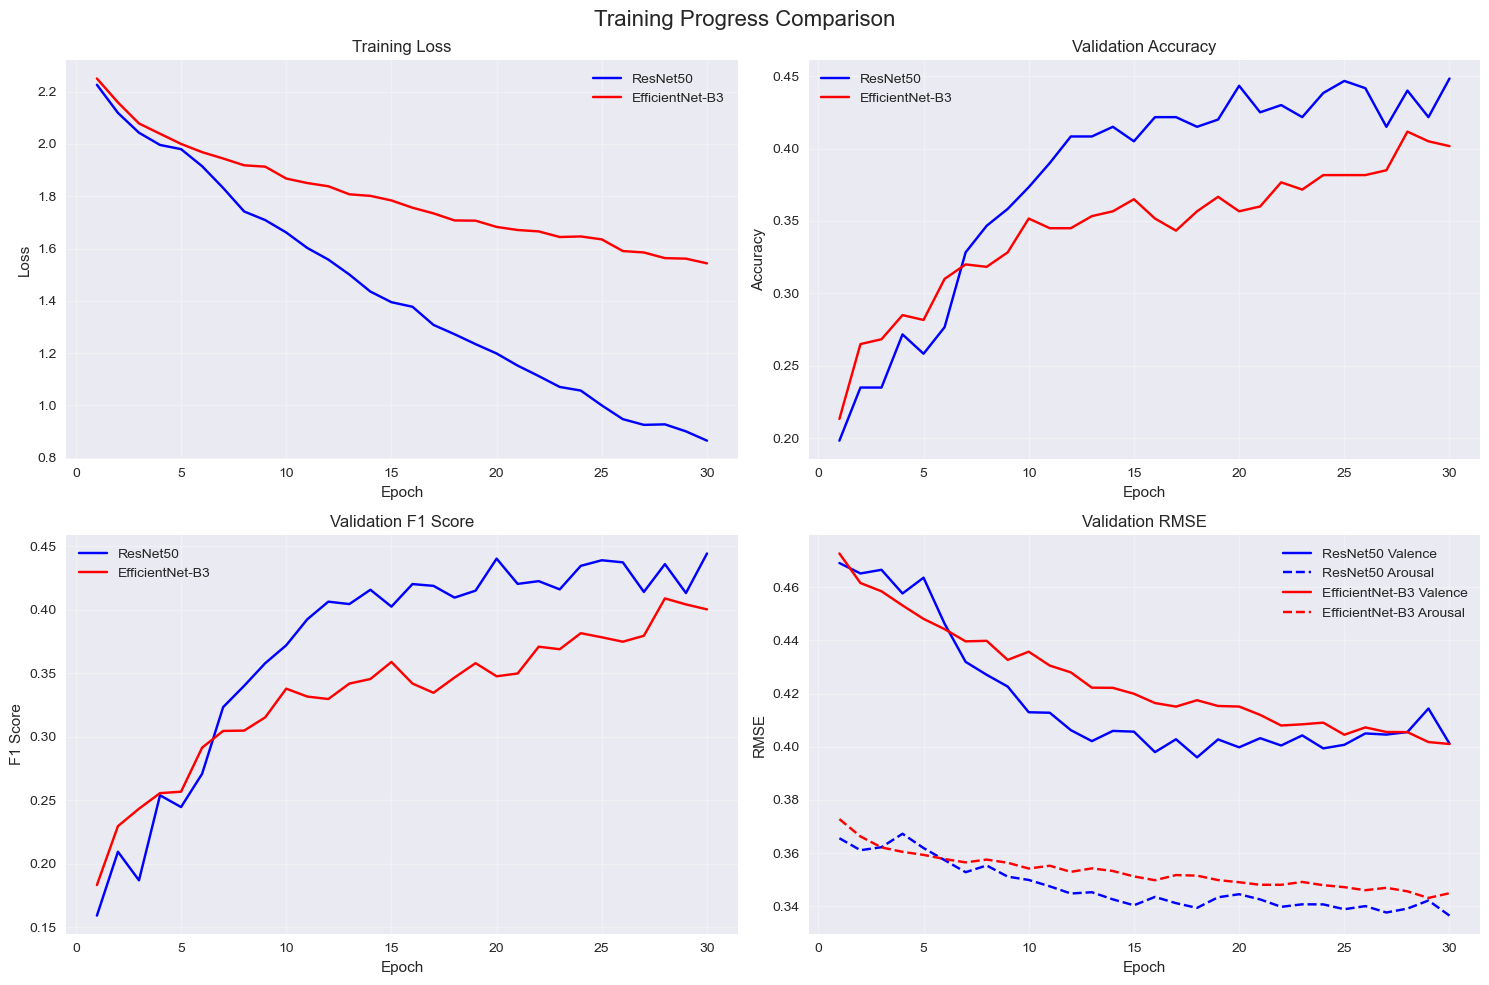

Generating confusion matrices


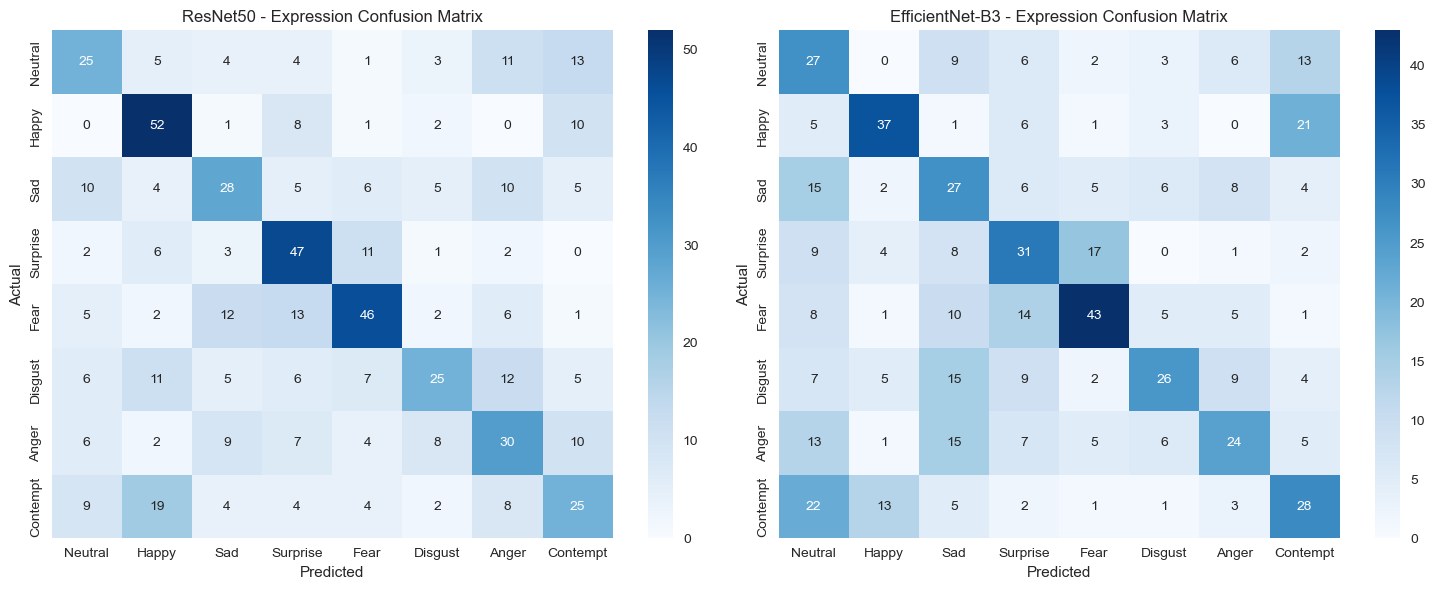

Showing sample predictions


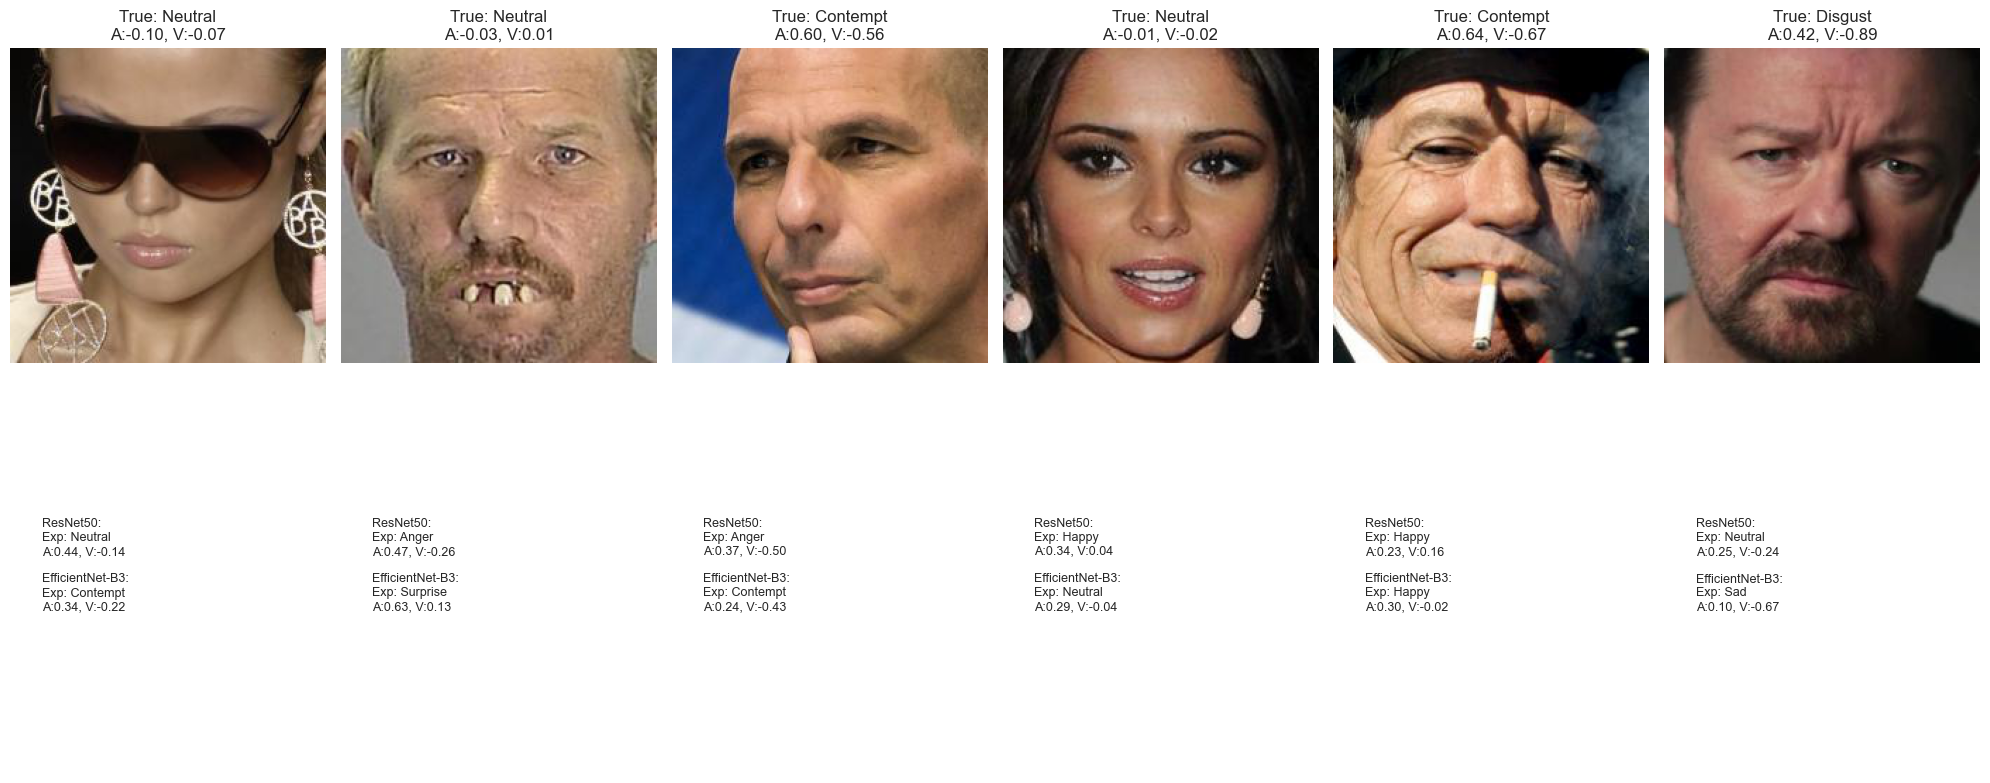

In [20]:
print("\nGENERATING VISUALIZATIONS")
print("-" * 40)

print("Plotting training curves")
plot_training_curves(training_results)

print("Generating confusion matrices")
plot_confusion_matrices(trained_models)

print("Showing sample predictions")
show_sample_predictions(trained_models, num_samples=6)